# EVALUACIÓN DE MODELOS PREENTRENADOS PARA LA ESTIMACIÓN DE EDAD CON IMÁGENES DE RADIOGRAFÍAS MAXILOFACIALES

# 1. Software

In [2]:
import os, sys
working_dir = os.getcwd()
print(f"Directorio actual: {working_dir}")
sys.path.append(os.path.abspath("src/"))

Directorio actual: /mnt/homeGPU/dgonzalez/tfg-bioprofile-uncertainty


In [ ]:
data_dir = working_dir + "/data/AE_maxillofacial/preprocessed/"
print(f"Directorio de los datos: {data_dir}")

Directorio de los datos: /mnt/homeGPU/dgonzalez/tfg-bioprofile-uncertainty/data/AE_maxillofacial/preprocessed/


In [4]:
#
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Manipulación de datos
import numpy as np
import pandas as pd
from PIL import Image

# Visualización de datos
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
plotly.io.renderers.default = "vscode"

# Modelos y funciones de pérdida personalizados 
from custom_models import *
from coverage_metrics import *


# 2. Carga de datos

In [5]:
# Define la clase MaxillofacialXRayDataset, que se utiliza para cargar imágenes de rayos X maxilofaciales 
# junto con su edad correspondiente desde un fichero de metadatos. 
class MaxillofacialXRayDataset(Dataset):
    
    def __init__(self, metadata_file, images_dir, transform=None):
        """
        metadata_file: Ruta al fichero de metadatos (CSV u otro formato)
        images_dir: Ruta al directorio de imágenes (entrenamiento o prueba)
        transform: Transformaciones a aplicar a las imágenes (normalización, etc.)
        """
        metadata = pd.read_csv(metadata_file)  
        self.images_dir = images_dir
        self.transform = transform
        
        # Preprocesar los campos una sola vez
        self.img_paths = metadata['ID'].apply(lambda id_: os.path.join(images_dir, id_)).tolist()
        self.sexes = torch.tensor((metadata['Sex'] != 'M').astype(int).values, dtype=torch.long)
        self.ages = torch.tensor(metadata['Age'].values, dtype=torch.float32)
    
    
    def __len__(self):
        return len(self.img_paths)
    
    
    def __getitem__(self, idx):
        
        # Carga la imagen
        image = Image.open(self.img_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, self.sexes[idx], self.ages[idx]

In [6]:
test_transform = transforms.Compose(
    [transforms.Resize((448, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))]
)

# Crea el Dataset de test con solo resize y normalización
testset  =  MaxillofacialXRayDataset(
    metadata_file = data_dir + 'metadata_test.csv',
    images_dir = data_dir + 'test/',
    transform = test_transform
) 

In [7]:
# Establece un batch size de 32 
BATCH_SIZE = 32

# Crea DataLoader de test
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

# 3. Obtención de resultados

In [ ]:
df = pd.DataFrame(columns=[
    "pred_model_type", 
    "sex_embedding",
    "confidence", 
    "pred_interval_width"
])

In [ ]:
MODEL_CLASSES = {
    'base': ResNeXtRegressor,
    'QR': ResNeXtRegressor_QR,
    'ICP': ResNeXtRegressor_ICP,
    'CQR': ResNeXtRegressor_CQR,
    'CRF': ResNeXtRegressor_CRF
}

def obtain_results(load_model_path):

    #
    checkpoint = torch.load(load_model_path, weights_only=False)
    pred_model_type = checkpoint['pred_model_type']
    use_metadata = checkpoint['use_metadata']
    confidence = 1-checkpoint['alpha']

    # Obtiene la clase del modelo basado en el checkpoint
    model_class = MODEL_CLASSES.get(checkpoint['pred_model_type'])

    # Crea el modelo
    model = model_class(
        confidence = confidence, 
        use_metadata = use_metadata, 
        meta_input_size = 1 if use_metadata else 0
    ).to('cuda')

    # Carga el modelo
    model.load_checkpoint(checkpoint)

    if pred_model_type == 'base':
        # Solo predicciones puntuales
        test_pred_point_values, test_true_values = model.inference(test_loader)
        
        # Calcula el MAE y lo imprime
        test_mae = torch.mean(torch.abs(test_true_values - test_pred_point_values))
        
        #
        if pred_model_type == 'base':
            test_pred_lower_bound = test_pred_point_values - 2 * test_mae
            test_pred_upper_bound = test_pred_point_values + 2 * test_mae
            
    else:
        # Predicciones puntuales e interválicas 
        test_pred_point_values, test_pred_lower_bound, test_pred_upper_bound, test_true_values = \
            model.inference(test_loader)
            
    interval_widths = test_pred_upper_bound - test_pred_lower_bound

    results = {
        "pred_model_type": checkpoint['pred_model_type'],
        "sex_embedding": checkpoint['use_metadata'],
        "confidence": checkpoint['confidence'] if 'confidence' in checkpoint else None,
        "interval_widths": interval_widths
    }
    
    return results

In [74]:
# results_base = obtain_results('models/AE_model01_base.pth')
# results_base_sex = obtain_results('models/AEsex_model01_base.pth')

results_ICP = obtain_results('models/AE_model02_ICP.pth')
results_ICP_sex = obtain_results('models/AEsex_model02_ICP.pth')

results_QR = obtain_results('models/AE_model03_QR.pth')
results_QR_sex = obtain_results('models/AEsex_model03_QR.pth')

# results_CQR = obtain_results('models/AE_model04_CQR.pth')
# results_CQR_sex = obtain_results('models/AEsex_model04_CQR.pth')

In [18]:
#
checkpoint = torch.load(load_model_path, weights_only=False)
pred_model_type = checkpoint['pred_model_type']
use_metadata = checkpoint['use_metadata']
confidence = 1-checkpoint['alpha']

In [19]:
MODEL_CLASSES = {
    'base': ResNeXtRegressor,
    'QR': ResNeXtRegressor_QR,
    'ICP': ResNeXtRegressor_ICP,
    'CQR': ResNeXtRegressor_CQR,
    'CRF': ResNeXtRegressor_CRF
}

# Obtiene la clase del modelo basado en el checkpoint
model_class = MODEL_CLASSES.get(checkpoint['pred_model_type'])

# Crea el modelo
model = model_class(
    confidence = confidence, 
    use_metadata = use_metadata, 
    meta_input_size = 1 if use_metadata else 0
).to('cuda')

# Carga el modelo
model.load_checkpoint(checkpoint)

# 4. Test

In [20]:
if pred_model_type == 'base':
    # Solo predicciones puntuales
    test_pred_point_values, test_true_values = model.inference(test_loader)
else:
    # Predicciones puntuales e interválicas 
    test_pred_point_values, test_pred_lower_bound, test_pred_upper_bound, test_true_values = \
        model.inference(test_loader)

In [21]:
#
print("Métricas de las predicciones puntuales:")

# Calcula el MAE y lo imprime
test_mae = torch.mean(torch.abs(test_true_values - test_pred_point_values))
print(f"- Error Absoluto Medio (MAE) en test: {test_mae:.3f}")

# Calcula e imprime el MSE y lo imprime
test_mse = torch.mean((test_true_values - test_pred_point_values) ** 2)
print(f"- Error Cuadrático Medio (MSE) en test: {test_mse:.3f}")

Métricas de las predicciones puntuales:
- Error Absoluto Medio (MAE) en test: 1.173
- Error Cuadrático Medio (MSE) en test: 2.407


In [22]:
#
if pred_model_type == 'base':
    test_pred_lower_bound = test_pred_point_values - 2 * test_mae
    test_pred_upper_bound = test_pred_point_values + 2 * test_mae

#
print("Métricas de las predicciones interválicas:")

# Calcula la cobertura empírica y lo imprime
EC = empirical_coverage(test_pred_lower_bound, test_pred_upper_bound, test_true_values)
print(f"- Cobertura empírica: {EC*100:>6.3f} %")

# Calcula el tamaño medio del intervalo de predicción y lo imprime
MPIW = mean_interval_size(test_pred_lower_bound, test_pred_upper_bound)
print(f"- Tamaño medio del intervalo: {MPIW:>5.3f}")

# Calcula el tamaño mínimo del intervalo de predicción y lo imprime
min_interval_size = quantile_interval_size(test_pred_lower_bound, test_pred_upper_bound, 0.0)
print(f"- Tamaño mínimo de los intervalos: {min_interval_size:>5.3f}")

# Calcula el tamaño máximo del intervalo de predicción y lo imprime
max_interval_size = quantile_interval_size(test_pred_lower_bound, test_pred_upper_bound, 1.0)
print(f"- Tamaño máximo de los intervalos: {max_interval_size:>5.3f}")

Métricas de las predicciones interválicas:
- Cobertura empírica: 79.461 %
- Tamaño medio del intervalo: 3.598
- Tamaño mínimo de los intervalos: 2.538
- Tamaño máximo de los intervalos: 4.492


In [13]:
from typing import Optional

def plot_confidence_predictions(
    pred_point_values : torch.Tensor,
    pred_lower_bound : torch.Tensor,
    pred_upper_bound : torch.Tensor,
    true_values : torch.Tensor
) -> None:
    
    # Convierte los tensores a NumPy
    y_true = true_values.numpy()
    y_pred = pred_point_values.numpy()
    y_lower = pred_lower_bound.numpy()
    y_upper = pred_upper_bound.numpy()
    
    # Ordena por los valores predichos
    order = np.argsort(y_pred)
    y_true = y_true[order]
    y_pred = y_pred[order]
    y_lower = y_lower[order]
    y_upper = y_upper[order]
    
    x = np.arange(len(y_true))
    
    # Grafica
    plt.figure(figsize=(12, 6))
    plt.plot(x, y_true, label='Valor verdadero', 
             color='black', linewidth=2, marker='s', markersize=4)
    plt.plot(x, y_pred, label='Predicción puntual', 
             color='steelblue', linestyle='--', marker='o', markersize=4)
    plt.fill_between(x, y_lower, y_upper, 
                     color='lightcoral', alpha=0.5, label='Intervalo de confianza')

    plt.xlabel('Instancia (ordenada por valor verdadero)')
    plt.ylabel('Valor')
    plt.title('Predicción con intervalos de confianza')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

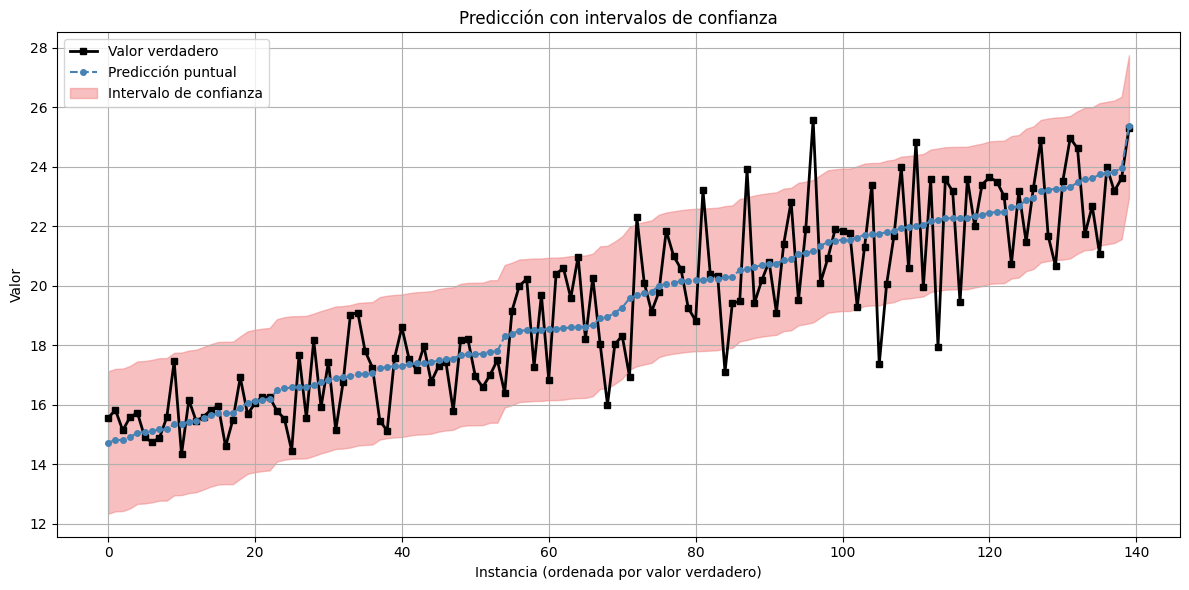

In [14]:
n = 140
plot_confidence_predictions(
    test_pred_point_values[0:n],
    test_pred_lower_bound[0:n],
    test_pred_upper_bound[0:n],
    test_true_values[0:n]
)

In [29]:
interval_widths = test_pred_upper_bound - test_pred_lower_bound



In [30]:
interval_widths

tensor([4.3853, 3.8385, 2.9209,  ..., 3.9063, 3.1680, 4.1211])

In [43]:
def plot_density_interval_widths(
    interval_widths : torch.Tensor
) -> None:
    
    #
    order = np.argsort(interval_widths)
    interval_widths_sorted = interval_widths[order]
    
    plt.figure(figsize=(10, 6))
    
    # Define el rango de los xticks basado en los datos
    xdif = interval_widths.max() - interval_widths.min()
    xmin = interval_widths.min() - 0.1 * xdif
    xmax = interval_widths.max() + 0.1 * xdif
    xticks = np.linspace(xmin, xmax, num=6)  # 6 ticks uniformemente distribuidos

    # Boxplot
    ax1 = plt.subplot(2, 1, 1)
    sns.boxplot(x=interval_widths_sorted, color='skyblue', ax=ax1)
    ax1.set_title('Boxplot de los anchos de los intervalos')
    ax1.set_xlabel('')
    ax1.set_xlim(xmin, xmax)
    ax1.set_xticks(xticks)
    ax1.grid(True)

    # KDE plot
    ax2 = plt.subplot(2, 1, 2, sharex=ax1)
    sns.kdeplot(interval_widths_sorted, fill=True, bw_adjust=0.5, color='orange', ax=ax2)
    ax2.set_title('Densidad de los anchos de los intervalos')
    ax2.set_xlabel('Ancho del intervalo')
    ax2.set_ylabel('Densidad')
    ax2.set_xlim(xmin, xmax)
    ax2.set_xticks(xticks)
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


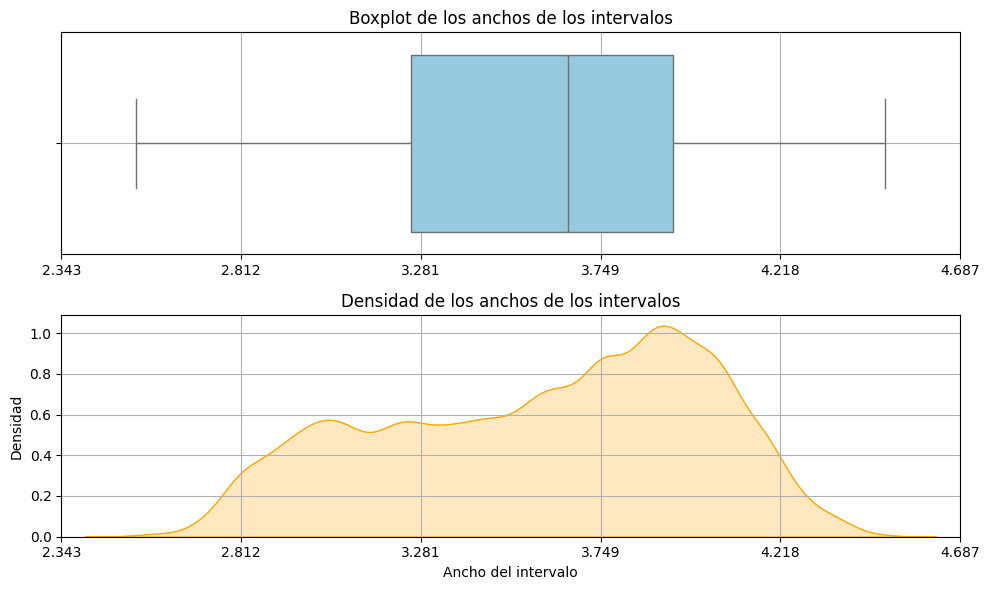

In [44]:
plot_density_interval_widths(interval_widths)

In [51]:
def plot_boxplot(
    *interval_widths: torch.Tensor
) -> None:
    
    # Convertir cada tensor a numpy y ordenar internamente
    data = [iw[torch.argsort(iw)].numpy() for iw in interval_widths]

    # Dibujar boxplots múltiples verticales
    plt.boxplot(data, vert=True)

    # Etiquetas para cada grupo
    plt.xticks(ticks=range(1, len(data)+1), labels=[f'Set {i+1}' for i in range(len(data))])
    plt.ylabel("Interval widths")
    plt.title("Boxplots múltiples de Interval Widths")

    plt.show()

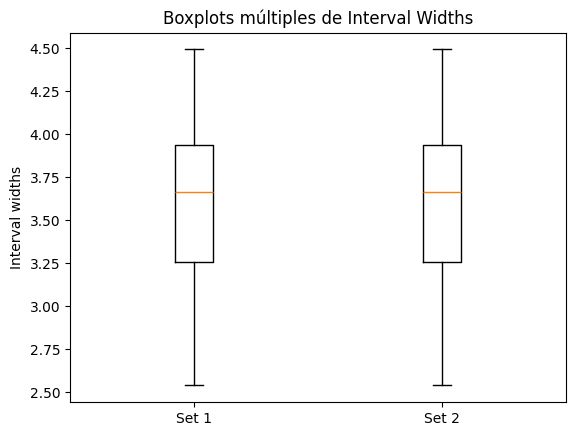

In [52]:
plot_boxplot(interval_widths, interval_widths)

In [63]:

from scipy.stats import gaussian_kde

def plot_boxplot_with_density(*interval_widths: torch.Tensor) -> None:
    data = [iw.numpy() for iw in interval_widths]
    n = len(data)

    plt.figure(figsize=(4*n, 6))

    max_density = 0  # Para normalizar densidades y que encajen bien
    densities = []
    y_vals_list = []

    # Primero estimamos todas las densidades y guardamos para normalizar luego
    for d in data:
        kde = gaussian_kde(d)
        y_vals = np.linspace(np.min(d), np.max(d), 200)
        density = kde(y_vals)
        densities.append(density)
        y_vals_list.append(y_vals)
        max_density = max(max_density, density.max())

    boxplot_positions = np.arange(1, n+1)
    boxplot_width = 0.35
    density_offset = 0.2  # distancia horizontal entre boxplot y densidad

    # Dibujar todos los boxplots en sus posiciones
    plt.boxplot(data, positions=boxplot_positions, widths=boxplot_width, vert=True)

    # Para cada conjunto, dibujar la densidad justo a la derecha del boxplot
    for i in range(n):
        # Normalizamos la densidad para que tenga máximo igual a boxplot_width (o un poco menos)
        scaled_density = densities[i] / max_density * boxplot_width

        # Dibujamos densidad desplazada en x
        x = boxplot_positions[i] + density_offset + scaled_density  # para rellenar hacia la derecha
        y = y_vals_list[i]

        # Usamos fill_betweenx para densidad vertical
        plt.fill_betweenx(y, boxplot_positions[i] + density_offset, x, alpha=0.5)

        # También dibujamos línea para densidad
        plt.plot(x, y, color='C0')

    plt.xticks(boxplot_positions, [f'Set {i+1}' for i in range(n)])
    plt.ylabel("Interval widths")
    plt.title("Boxplots con densidad al lado en la misma figura")

    plt.tight_layout()
    plt.show()

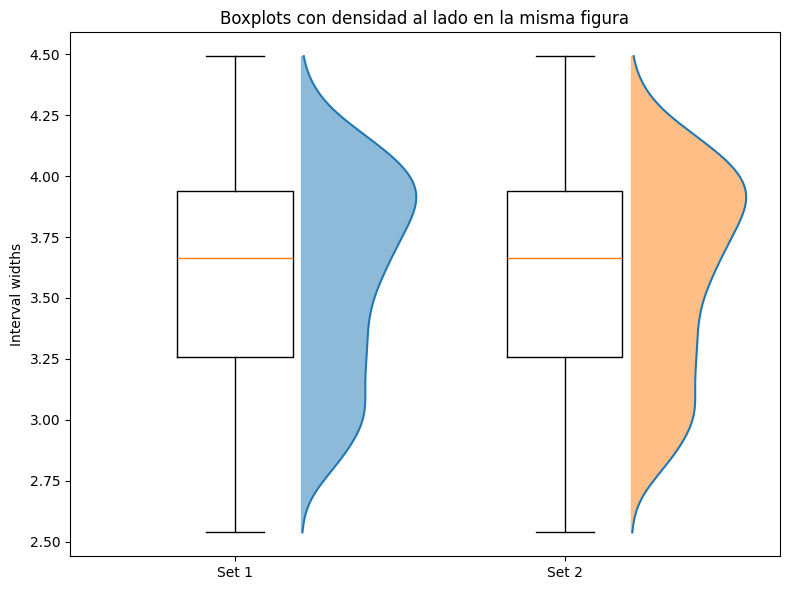

In [64]:
plot_boxplot_with_density(interval_widths, interval_widths)

In [71]:
def plot_density_interval_widths(interval_widths: torch.Tensor) -> None:
    # Ordenamos los valores
    order = np.argsort(interval_widths.numpy())  # convertimos tensor a numpy para argsort
    interval_widths_sorted = interval_widths[order]

    # Convertimos a numpy para seaborn
    data_np = interval_widths_sorted.numpy()

    # Crear un DataFrame para seaborn
    df = pd.DataFrame({'interval_widths': data_np})

    # Graficar violin plot
    plt.figure(figsize=(8, 6))
    sns.violinplot(y='interval_widths', data=df, fill=False, inner="quart")
    plt.title('Violin Plot de Interval Widths')
    plt.ylabel('Interval Width')
    plt.show()


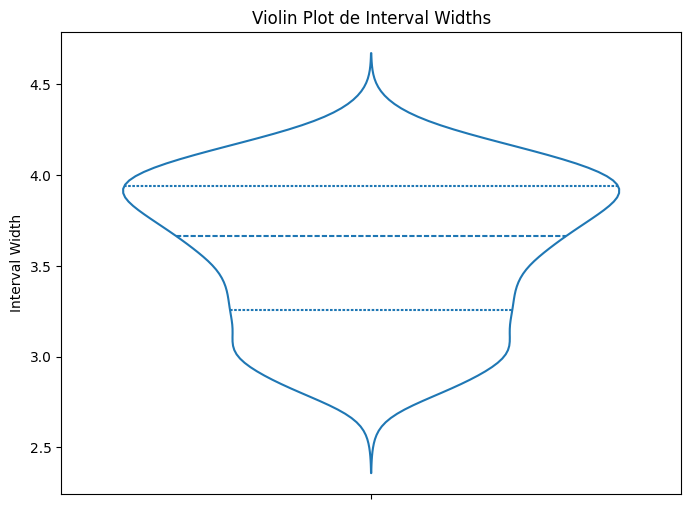

In [72]:
plot_density_interval_widths(interval_widths)

Obtención de datos